In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffusion1ch import Unet, GaussianDiffusion, Trainer, Dataset, SimpleDataset
device = 'cuda:0'

import matplotlib.pyplot as plt
import torch

In [5]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 2, 4, 4, 8, 8)
).to(device)

diffusion = GaussianDiffusion(
    model,
    timesteps = 2000,   # number of steps
    loss_type = 'l1+l2'    # L1 or L2
).to(device)

lr = 2e-5
steps = 5000

trainer = Trainer(
    diffusion,
    '../../../datasets/femurDCMs',
    image_size = 256,   #256,
    train_batch_size = 16,
    train_lr = lr,
    train_num_steps = 500000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps  #2
    ema_decay = 0.998,                # exponential moving average decay
    fp16 = False,                       # turn on mixed precision training with apex
    results_folder = 'results_CT',
)

trainer.load('model-65000.pt') # <step> = # in the name

shape = 256

Loading from results_CT/model-65000.pt


In [2]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 2, 4, 4, 8, 8, 16)
).to(device)

diffusion = GaussianDiffusion(
    model,
    timesteps = 2000,   # number of steps
    loss_type = 'l1+l2'    # L1 or L2
).to(device)

lr = 2e-5
steps = 5000

trainer = Trainer(
    diffusion,
    '../../../datasets/CelebA_HQM',
    image_size = 128,
    train_batch_size = 64,
    train_lr = lr,
    train_num_steps = 500000,         # total training steps
    gradient_accumulate_every = 1,    # gradient accumulation steps
    ema_decay = 0.999,                # exponential moving average decay
    fp16 = False,                       # turn on mixed precision training with apex
    results_folder = './results_128'
)

trainer.load(195000) # <step> = # in the name

shape = 128

Loading from results_128/model-195000.pt


Loading from results_128/model-45000.pt


In [6]:
d = Dataset('../../../datasets/femurDCMs', shape)
seeded_images = torch.cat([d[x].unsqueeze(0) for x in [1, 2, 3, 4]], dim=0).to(device)

samples=4
noise = torch.randn(samples, 3, shape, shape).to(device)

In [7]:
mask = torch.full_like(seeded_images, 0, dtype=bool)

# Random noise mask
# mask[torch.rand_like(seeded_images) < .3] = 1

#Make 1/2 res mask
divisor = 2
for i in range(int(mask.shape[2]/divisor)):
    for j in range(int(mask.shape[3]/divisor)):
        mask[:,:,i*divisor,j*divisor]=1
        
mask = mask.to(device)
mask.shape

# all_images_list = list(map(lambda n: trainer.ema_model.sample(256, batch_size=1, noise=seeded_images, mask=mask), [1]))
# all_images = torch.cat(all_images_list, dim=0)

torch.Size([4, 1, 256, 256])

In [ ]:
# Unconditional generation

all_images_list = list(map(lambda n: trainer.ema_model.sample(shape, batch_size=4, noise=noise, mask=None), [4]))
all_images = torch.cat(all_images_list, dim=0)

In [8]:
all_images_list = list(map(lambda n: trainer.ema_model.sample(shape, batch_size=4, noise=seeded_images, mask=mask), [4]))
all_images = torch.cat(all_images_list, dim=0)

sampling loop time step: 100%|██████████| 2000/2000 [06:41<00:00,  4.98it/s]


In [54]:
shape=128
print(seeded_images.shape)
print(all_images.shape)
testim = all_images.reshape(-1, 4, 3, shape, shape).permute(1, 0, 2, 3, 4).reshape(-1, 3, shape, shape)
testim = [img.permute(1, 2, 0).detach().cpu() for img in testim]

print(testim[0].shape)
ixs = [8, 17, 26, 35]
badimgs = [all_images[idx,:,:,:] for idx in ixs]
# for idx in ixs:
#     plt.imshow(testim[idx])
#     plt.show()
    
print(badimgs[0].shape)

torch.Size([4, 3, 128, 128])
torch.Size([36, 3, 128, 128])
torch.Size([128, 128, 3])
torch.Size([3, 128, 128])


In [56]:
badimgs = [all_images[idx,:,:,:] for idx in ixs]
badimgs = torch.stack(badimgs,dim=0)
badimgs.shape

upmkr = nn.Upsample(size=None, scale_factor=2, mode='nearest', align_corners=None)
badimgs = upmkr(badimgs)
badimgs.shape

torch.Size([4, 3, 256, 256])

In [61]:
mask = torch.full_like(badimgs, 0, dtype=bool)

# Random noise mask
# mask[torch.rand_like(seeded_images) < .3] = 1

#Make 1/2 res mask
divisor = 2
for i in range(int(mask.shape[2]/divisor)):
    for j in range(int(mask.shape[3]/divisor)):
        mask[:,:,i*divisor,j*divisor]=1
        
mask = mask.to(device)
mask.shape

# all_images_list = list(map(lambda n: trainer.ema_model.sample(256, batch_size=1, noise=seeded_images, mask=mask), [1]))
# all_images = torch.cat(all_images_list, dim=0)

torch.Size([4, 3, 256, 256])

In [62]:
#stage2 cascade
shape=256
all_images_list = list(map(lambda n: trainer.ema_model.sample(shape, batch_size=4, noise=badimgs, mask=mask), [4]))
all_images = torch.cat(all_images_list, dim=0)

sampling loop time step: 100%|██████████| 2000/2000 [07:41<00:00,  4.33it/s]


In [11]:
output_images = all_images.reshape(-1, 4, 1, shape, shape).permute(1, 0, 2, 3, 4).reshape(-1, 1, shape, shape)
output_images = [img.permute(1, 2, 0).detach().cpu() for img in output_images]

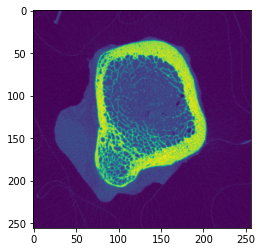

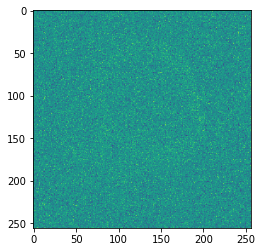

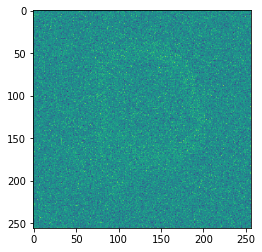

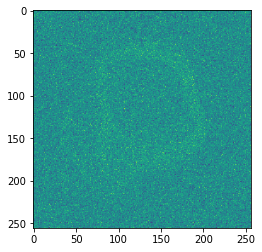

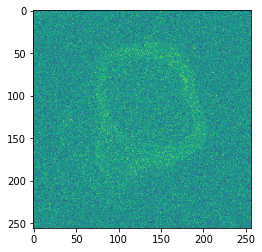

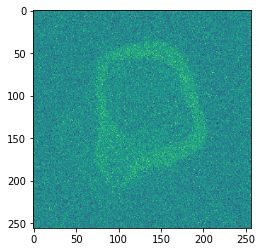

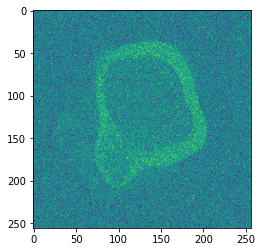

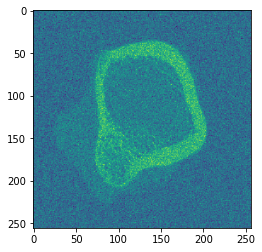

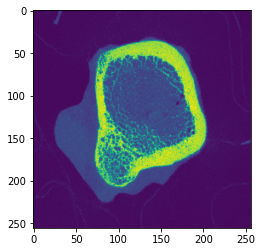

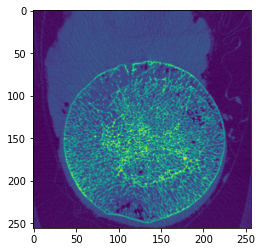

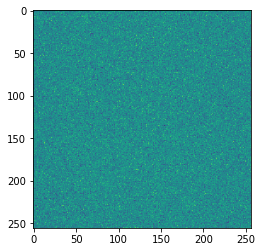

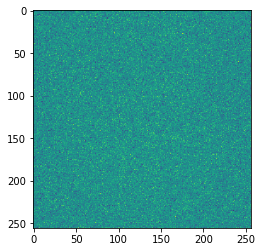

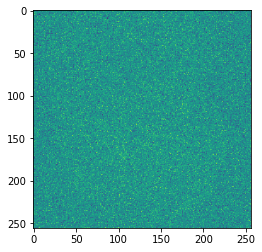

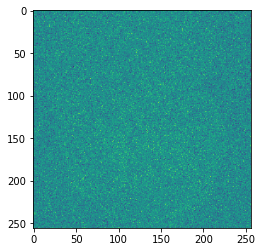

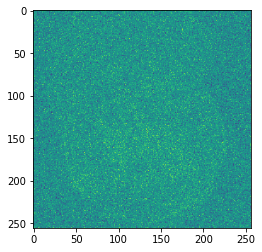

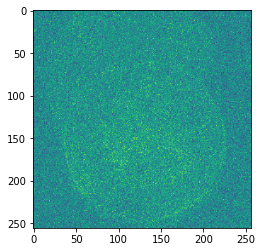

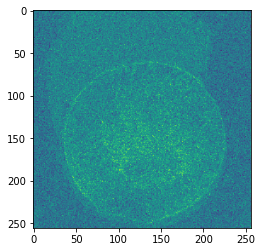

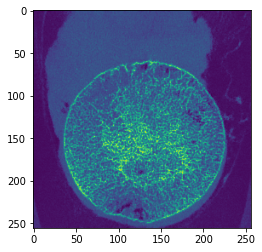

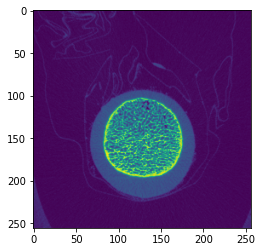

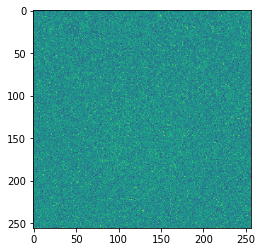

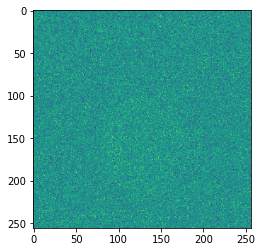

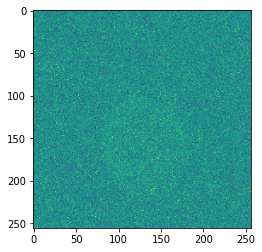

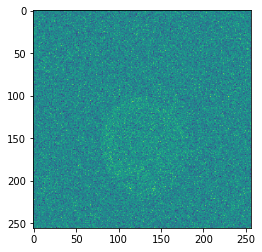

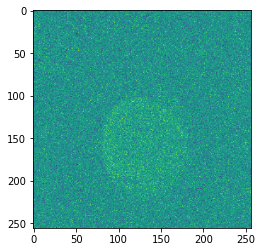

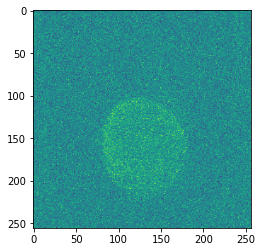

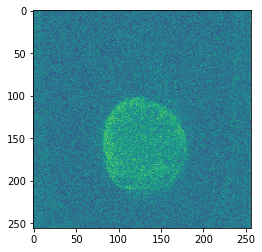

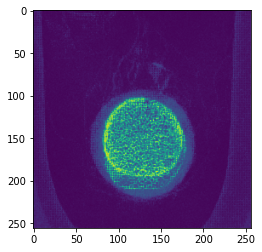

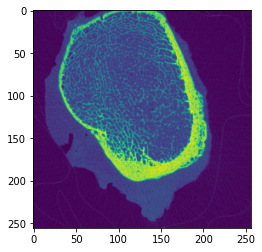

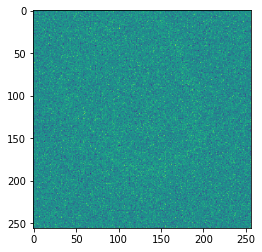

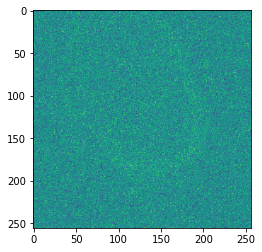

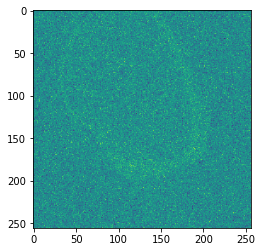

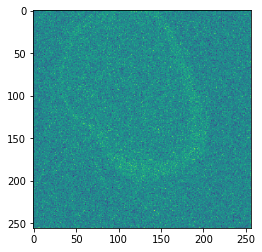

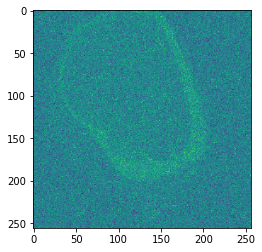

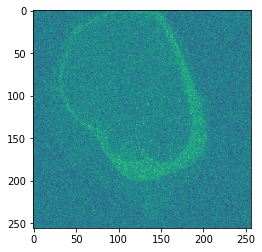

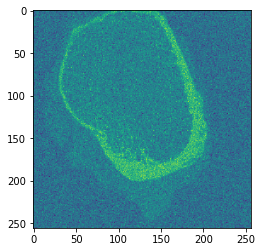

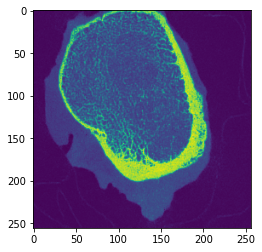

In [12]:
for x in output_images:
    plt.imshow(x)
    plt.show()

In [ ]:
for i in range(0,4):
    plt.imshow(np.bitwise_and(output_images[9*i + 8],mask)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


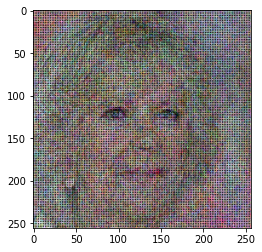

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


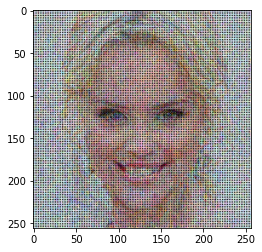

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


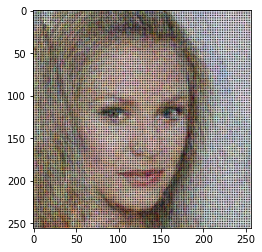

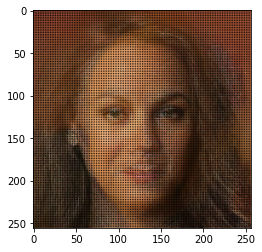

In [97]:
import numpy as np
for i in range(4):
    xx = output_images[9*i + 8].numpy() * np.invert(mask[0,:,:,:].permute(1,2,0).cpu().numpy())
    xx.shape
    plt.imshow(xx)
    plt.show()

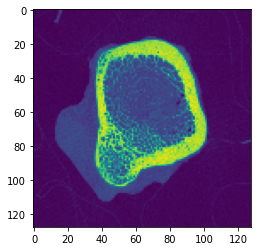

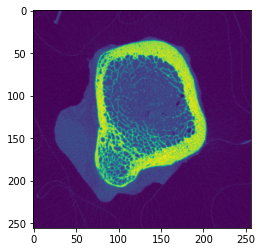

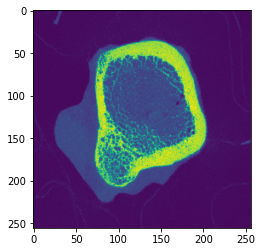

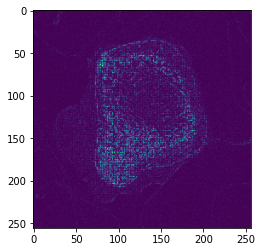

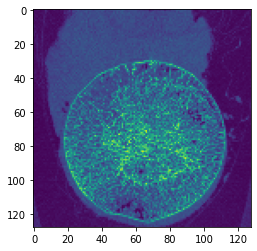

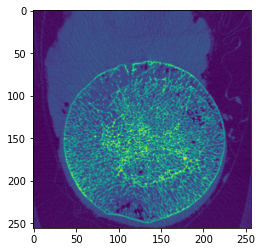

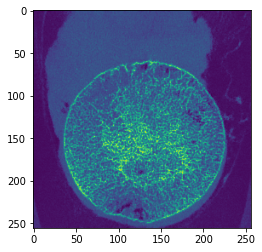

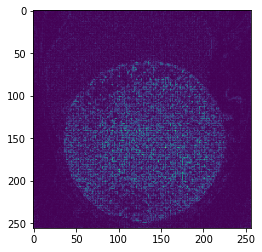

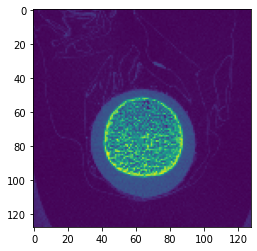

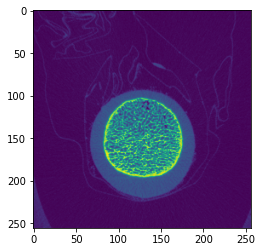

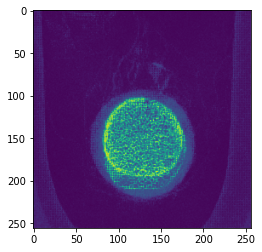

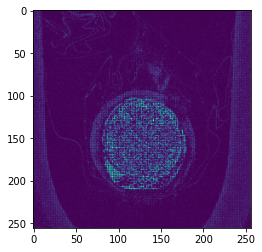

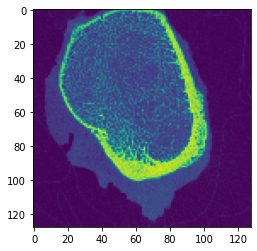

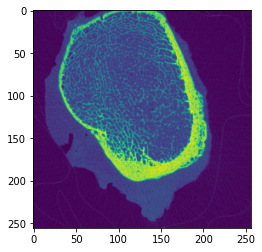

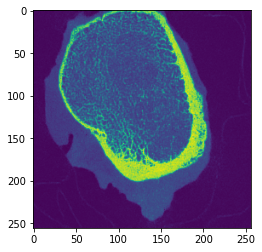

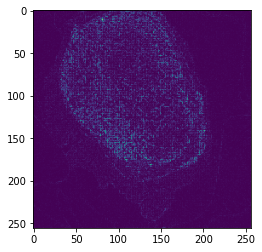

In [13]:
from torch import nn

for i in range(0, 4):
    plt.imshow(output_images[9*i][0::divisor,0::divisor])
    plt.show()
    plt.imshow(output_images[9*i])
    plt.show()
    plt.imshow(output_images[9*i + 8])
    plt.show()
    plt.imshow((output_images[9*i] - output_images[9*i + 8]).abs()*10)
    plt.show()


In [ ]:
# Box mas
mask = torch.full_like(seeded_images, 1, dtype=bool)
_, _, h, w = mask.shape
# mask[:, :, 0:h//2, :] = 0
mask[:, :, h*30//100:h*52//100, w*17//100:w*83//100] = 0
mask[:, :, h*30//100:h*52//100, w*42//100:w*58//100] = 1
# mask[:, :, h*20//100:h*80//100, w*20//100:w*80//100] = 0
# mask[:, :, h*30//100:h*70//100, w*30//100:w*70//100] = 1
# mask[:, :, h*40//100:h*60//100, w*40//100:w*60//100] = 0
# mask[:, :, h*45//100:h*55//100, w*45//100:w*55//100] = 1
# mask[:, :, h*25//100:h*75//100, w*24//100:w*75//100] = 1
mask = mask.to(device)
